In [1]:
%matplotlib widget

In [2]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

### Load lattice

In [3]:
env = xt.Environment()
env.call('../fccee_z_lattice.py')
env.call('../002_design_optics/quad_strength_limits.py')
env.call('../002_design_optics/matching_constraints.py')

### Select line to match

In [4]:
line = -env['ccs_yl'] + (-env['ccs_xl'])

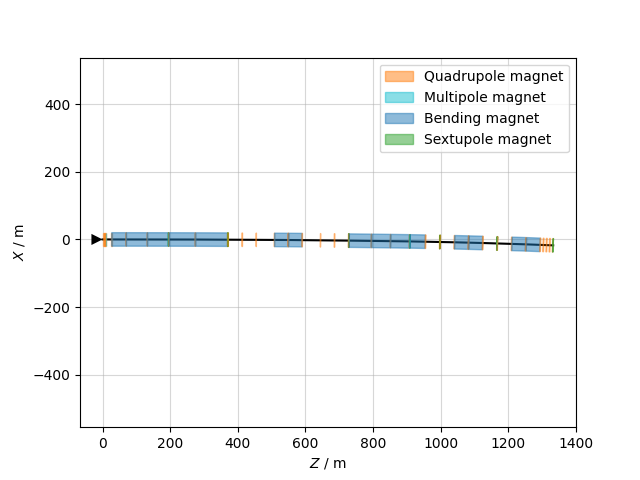

In [5]:
# Inspect lattice
line.survey().plot()

### Load strengths from CCS-Y match

In [6]:
env.vars.load_json('strengths_quads_01_ffccsyl.json')

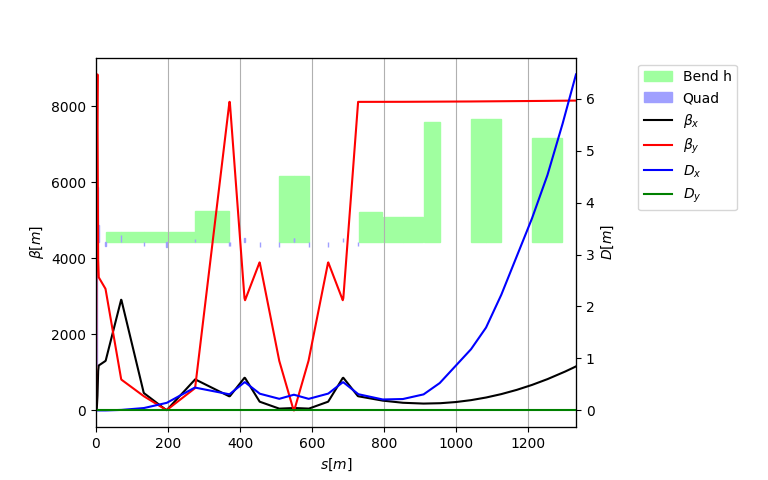

In [7]:
line.twiss(betx=env['bxip'], bety=env['byip']).plot()

### Structure of the lattice

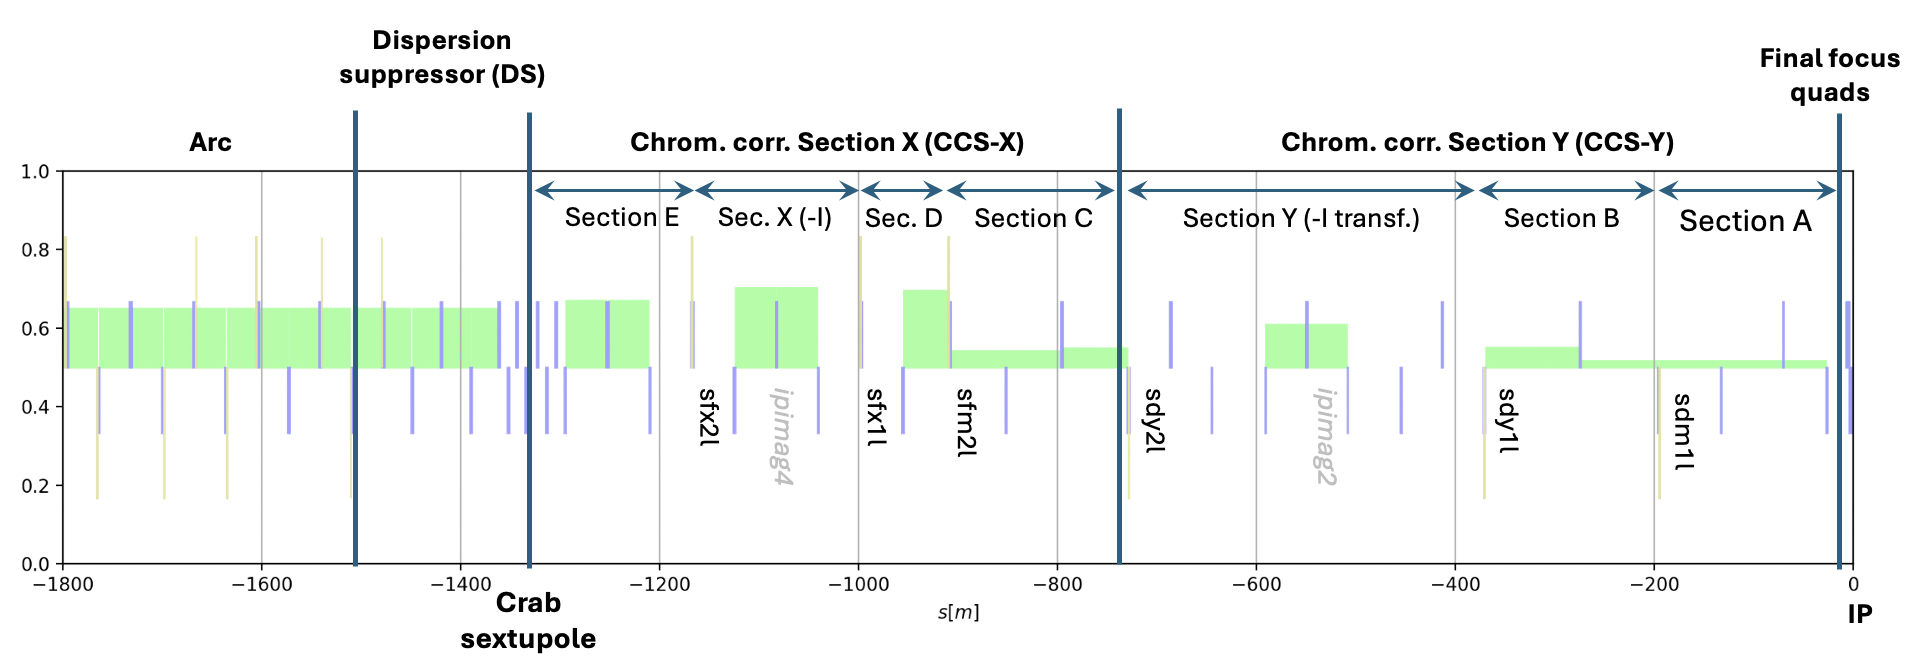

In [8]:
kq_section_c = ['kqd07l', 'kqf08l', 'kqd09l', 'kqf10l']
kq_section_d = ['kqd11l', 'kqf12l']
kq_xquads =    ['kqx00l', 'kqx01l', 'kqx02l']
kq_section_e = ['kqf13l', 'kqd14l', 'kqf15l', 'kqd16l',
                   'kqf17l', 'kqd18l', 'kqf19l', 'kqd20l']

In [9]:
# Initialize quadrupoles with a small strength
for nn in kq_section_c + kq_section_d + kq_xquads + kq_section_e:
    if line.vars.vary_default[nn]['limits'][1] > 1e-3: # Focusing quad
        line[nn] = 1e-3
    else: # Defocusing quad
        line[nn] = -1e-3

### Match section C

In [10]:
opt_section_c = line.match(
    name='section_c',
    solve=False,
    betx=env['bxip'], bety=env['byip'],
    default_tol=1e-5,
    vary=xt.VaryList(kq_section_c, step=1e-10),
    targets=[
        xt.TargetSet(betx=xt.LessThan(27.0), bety=xt.LessThan(15.0),
                     alfx=xt.GreaterThan(0.), alfy=xt.GreaterThan(0.5),
                     dx=xt.GreaterThan(0.235), at='sfm2l::0'),
        xt.TargetSet(alfy=xt.LessThan(0.9), dx=xt.LessThan(0.25),
                     at='sfm2l::0')])
opt = opt_section_c

In [11]:
# Alternate two optimizers
opt.run_jacobian(20)
opt.run_simplex(1000)

                                             
Optimize [section_c] - start penalty: 7856                         
Matching: model call n. 176 penalty = 2.2546e+02              
Optimize [section_c] - end penalty:  225.465                            
                                             
Optimize [section_c] - start penalty: 225.5                         
Matching: model call n. 301 penalty = 0.0000e+00              
Optimize [section_c] - end penalty:     0                            


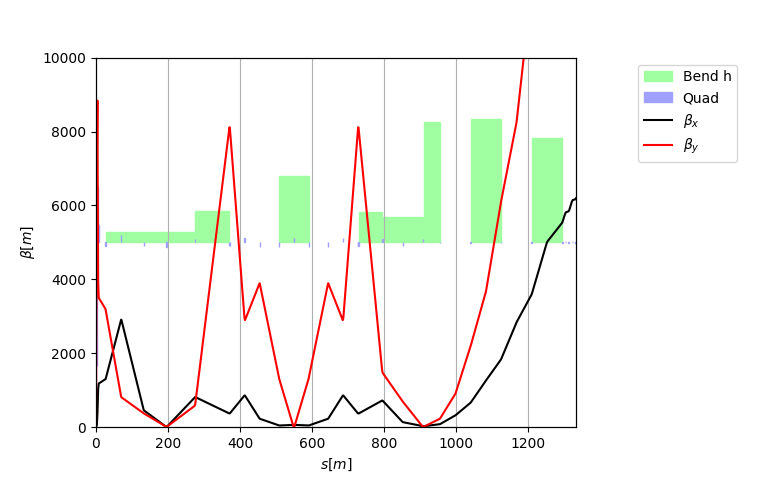

In [12]:
pp=opt.plot('betx bety')
pp.ylim(left_lo=0, left_hi=10000)

### Match section D

In [13]:
opt_section_d = opt_section_c.clone(name='section_d',
          remove_vary=True,
          add_vary=xt.VaryList(kq_section_d, step=1e-10),
          add_targets=xt.TargetSet(betx=xt.GreaterThan(1000.),
             alfx=0,
             bety=xt.LessThan(45.),
             dx=xt.LessThan(0.6),
             mux=1.75 - 0.0093,
             at='sfx1l::1'))
opt = opt_section_d

In [14]:
opt.run_jacobian(20)

                                             
Optimize [section_d] - start penalty: 1096                         
Matching: model call n. 110 penalty = 8.9606e-01              
Optimize [section_d] - end penalty:  0.896059                            


### Match sections C and D together

In [15]:
opt_sections_cd = opt_section_d.clone(
    name='sfx1l_cd',
    add_vary=opt_section_c.vary)
opt = opt_sections_cd

In [16]:
opt.run_jacobian(20)

                                             
Optimize [sfx1l_cd] - start penalty: 0.8961                         
Matching: model call n. 54 penalty = 1.0623e-07              
Optimize [sfx1l_cd] - end penalty:  1.06225e-07                            


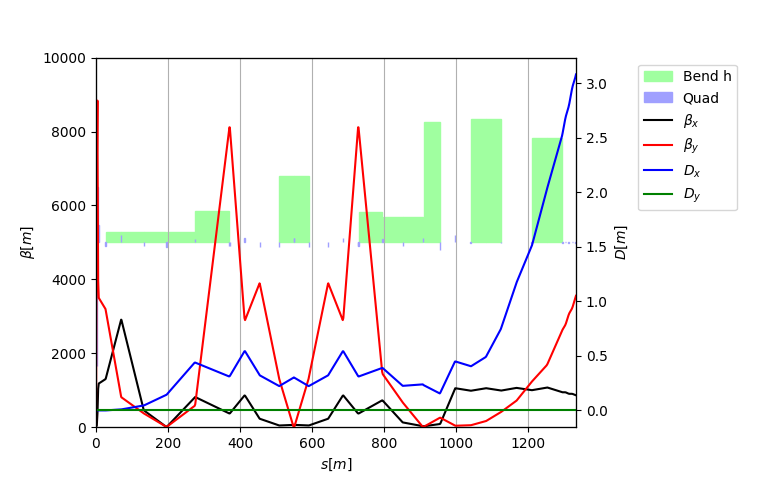

In [17]:
pp=opt.plot()
pp.ylim(left_lo=0, left_hi=10000)

#### Match Section X (-I transform.)

In [18]:
# Match r matrix alone
opt_section_x = line.match(
    name='section_x',
    solve=False,
    default_tol=1e-4,
    start='sfx1l::1', end='sfx2l::1',
    init_at='ipimag4',
    betx=0.20, bety=0.20, # Rough estimate
    targets=xt.TargetRmatrix(start='sfx1l::1', end='sfx2l::1',
                r12=env['r12_ccsxl'], r34=env['r34_ccsxl'],
                r11=-1, r33=-1),
    vary=xt.VaryList(kq_xquads, step=1e-10)
)
opt = opt_section_x
opt.targets['r33'].tol = 1e-3
opt.targets['r11'].tol = 2e-4

opt.disable(target=True)
opt.enable(target=0)
opt.step(20)
opt.enable(target=1)
opt.step(20)
opt.enable(target=2)
opt.step(20)
opt.enable(target=3)
opt.step(20)

                                             
Optimize [section_x] - start penalty: 1.991                         
Matching: model call n. 46 penalty = 1.1873e-05              
Optimize [section_x] - end penalty:  1.1873e-05                            
                                             
Optimize [section_x] - start penalty: 0.1619                         
Matching: model call n. 67 penalty = 3.4842e-06              
Optimize [section_x] - end penalty:  3.48425e-06                            
                                             
Optimize [section_x] - start penalty: 8.106                         
Matching: model call n. 210 penalty = 8.4002e-02              
Optimize [section_x] - end penalty:  0.084002                            
                                             
Optimize [section_x] - start penalty: 53.93                         
Matching: model call n. 236 penalty = 1.2641e-04              
Optimize [section_x] - end penalty:  0.000126407              

In [19]:
opt.target_status()

Target status:               enalty = 1.2641e-04              
id state tag tol_met       residue   current_val    target_val description                                 
0  ON    r11    True   0.000100175       -0.9999            -1 r11(sfx1l::1, sfx2l::1, val=-1, tol=0.00 ...
1  ON    r12    True  -3.97508e-05      -0.10004          -0.1 r12(sfx1l::1, sfx2l::1, val=-0.1, tol=0. ...
2  ON    r33    True   6.60462e-05     -0.999934            -1 r33(sfx1l::1, sfx2l::1, val=-1, tol=0.00 ...
3  ON    r34    True   1.20772e-06   1.20772e-06             0 r34(sfx1l::1, sfx2l::1, val=0.0, tol=0.0 ...


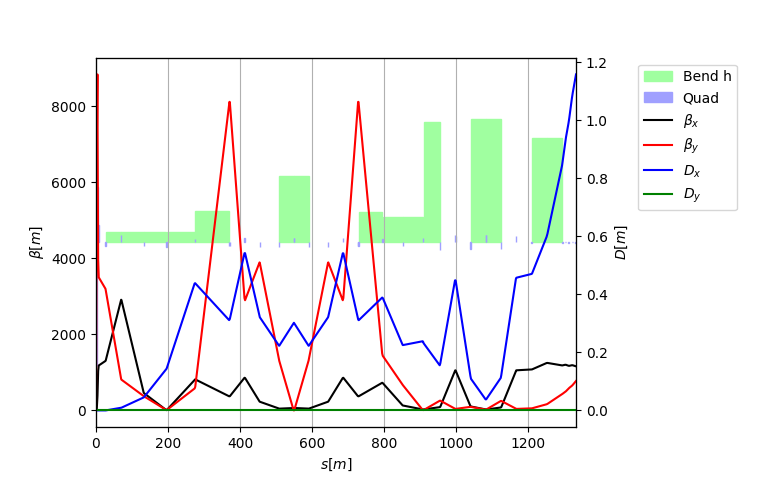

In [20]:
pp = opt_sections_cd.plot()

### Control optics at image point

In [21]:
# We start using only quadrupoles upstream (sections c and d)
opt_imag4 = opt_sections_cd.clone(name='imag4',
                            add_targets=xt.TargetSet(betx=xt.LessThan(20), bety=xt.LessThan(25.),
                                         alfx=0, alfy=env['delta_alfy_ccsx'],
                                         dx=xt.GreaterThan(2e-3),
                                         dpx=env['dpx_ccxl'],
                                         at='ipimag4'))
opt = opt_imag4
opt.run_jacobian(20)

                                             
Optimize [imag4] - start penalty: 7.914                         
Matching: model call n. 190 penalty = 3.7654e+00              
Optimize [imag4] - end penalty:  3.76535                            


In [22]:
opt.target_mismatch()

Target mismatch:             enalty = 3.7654e+00              
id state tag           tol_met       residue   current_val target_val   description                                 
9  ON    sfx1l::1_alfx   False      0.291735      0.291735 0            ('alfx', 'sfx1l::1'), val=0, tol=1e-05,  ...
10 ON    sfx1l::1_mux    False    1.4994e-05       1.74071 1.7407       ('mux', 'sfx1l::1'), val=1.7407, tol=1e- ...
12 ON    ipimag4_betx    False     -0.729014        20.729 LessThan(20) ('betx', 'ipimag4'), val=LessThan(20), t ...
14 ON    ipimag4_alfx    False      0.226617      0.226617 0            ('alfx', 'ipimag4'), val=0, tol=1e-05, w ...


In [23]:
# Focus on optics at sextupole
opt.disable(target=True)
opt.enable(target='sfx1l.*')
opt.target_status()

Target status:               enalty = 2.9173e+00              
id state tag           tol_met       residue   current_val target_val         description                                 
0  OFF   sfm2l::0_betx    True             0       25.9259 LessThan(27)       ('betx', 'sfm2l::0'), val=LessThan(27),  ...
1  OFF   sfm2l::0_bety    True             0       12.6565 LessThan(15)       ('bety', 'sfm2l::0'), val=LessThan(15),  ...
2  OFF   sfm2l::0_alfx    True             0      0.522163 GreaterThan(0)     ('alfx', 'sfm2l::0'), val=GreaterThan(0) ...
3  OFF   sfm2l::0_alfy    True             0      0.744124 GreaterThan(0.5)   ('alfy', 'sfm2l::0'), val=GreaterThan(0. ...
4  OFF   sfm2l::0_dx      True             0      0.244286 GreaterThan(0.235) ('dx', 'sfm2l::0'), val=GreaterThan(0.23 ...
5  OFF   sfm2l::0_alfy    True             0      0.744124 LessThan(0.9)      ('alfy', 'sfm2l::0'), val=LessThan(0.9), ...
6  OFF   sfm2l::0_dx      True             0      0.244286 LessThan(0.25)   

In [24]:
opt.run_jacobian(200)
opt.enable(target=True) # Enable all targets

                                             
Optimize [imag4] - start penalty: 2.917                         
Matching: model call n. 238 penalty = 4.1669e-05              
Optimize [imag4] - end penalty:  4.16688e-05                            


In [25]:
# We now use also quadrupoles in section X (preseting R matrix constraints)
opt_imag4_full = opt_imag4.clone(name='imag4',
            add_vary=opt_section_x.vary,
            add_targets=list(opt_section_x.targets)
)
opt = opt_imag4_full

In [26]:
opt.run_jacobian(20)
opt.run_simplex(1000)

                                             
Optimize [imag4] - start penalty: 10.15                         
Matching: model call n. 274 penalty = 1.2044e-02              
Optimize [imag4] - end penalty:  0.0120437                            
                                             
Optimize [imag4] - start penalty: 0.01204                         
Matching: model call n. 1869 penalty = 4.0929e-03              
Optimize [imag4] - end penalty:  0.00409287                            


In [27]:
opt.targets['ipimag4_dx'].weight = 10000
opt.targets['ipimag4_dpx'].weight = 1e6
opt.targets['sfx1l::1_mux'].weight = 10000
opt.run_nelder_mead(1000)

                                             
Optimize [imag4] - start penalty: 2.722                         
Matching: model call n. 3399 penalty = 2.2574e-01              
Optimize [imag4] - end penalty:  0.225742                            


In [28]:
opt.target_mismatch()

Target mismatch:             penalty = 2.2574e-01              
id state tag           tol_met       residue   current_val target_val         description                                 
4  ON    sfm2l::0_dx     False  -0.000154792      0.234845 GreaterThan(0.235) ('dx', 'sfm2l::0'), val=GreaterThan(0.23 ...
9  ON    sfx1l::1_alfx   False   -0.00206603   -0.00206603 0                  ('alfx', 'sfx1l::1'), val=0, tol=1e-05,  ...
13 ON    ipimag4_bety    False    -0.0867609       25.0868 LessThan(25)       ('bety', 'ipimag4'), val=LessThan(25), t ...
14 ON    ipimag4_alfx    False    0.00334484    0.00334484 0                  ('alfx', 'ipimag4'), val=0, tol=1e-05, w ...
15 ON    ipimag4_alfy    False     0.0192521     -0.180748 -0.2               ('alfy', 'ipimag4'), val=-0.2, tol=1e-05 ...
19 ON    r12             False    0.00961114    -0.0903889 -0.1               r12(sfx1l::1, sfx2l::1, val=-0.1, tol=0. ...
21 ON    r34             False    -0.0371576    -0.0371576 0.0             

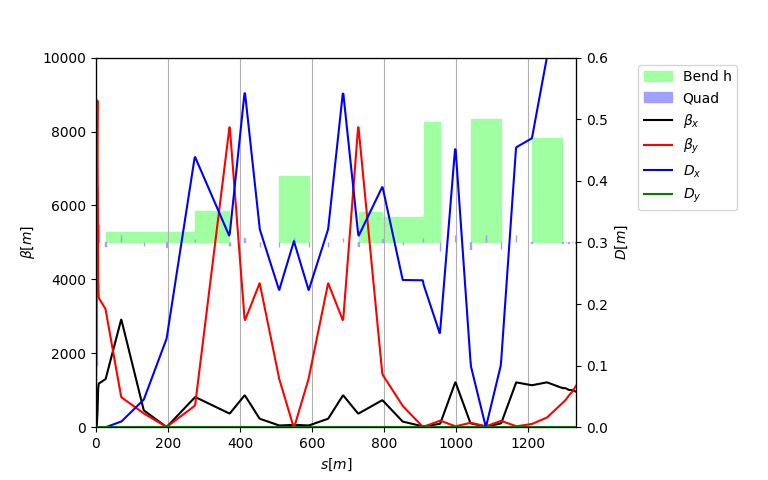

In [29]:
pp=opt.plot()
pp.ylim(left_lo=0, left_hi=10000, right_lo=0, right_hi=.6)

### Match optics at end CCS-X section (crab sextupole location)

In [30]:
# Try to close with Section E quadrupoles alone
opt_end = opt_imag4.clone(
    name='end',
    remove_vary=True,
    remove_targets=True,
    add_vary=xt.VaryList(kq_section_e, step=1e-10),
    add_targets=[xt.TargetSet(
                       betx=env['bx_ff_out'], alfx=0.0,
                       bety=env['by_ff_out'], alfy = 0.0,
                       dx=env['dx_ff_out'], dpx=0.0,
                       mux=3.0, muy=2.75, at=xt.END),
                 xt.TargetSet(dx=0, dpx=0, at='qf17l'), # to prevent dx going wild in the straight
                 xt.TargetSet(dx=0, dpx=0, at='qd18l'), # to prevent dx going wild in the straight
                 xt.TargetSet(bety=xt.LessThan(2000), at='qf17l'),
                 xt.TargetSet(bety=xt.LessThan(2000), at='qd18l'),
                 xt.TargetSet(bety=xt.LessThan(2000), at='qf19l'),
                 xt.TargetSet(bety=xt.LessThan(2000), at='qd20l'),
                 xt.TargetSet(bety=xt.GreaterThan(750), at='qf19l'),
    ]
)
opt = opt_end

In [31]:
opt.run_jacobian(10)

                                             
Optimize [end] - start penalty: 1015                         
Matching: model call n. 129 penalty = 4.5482e+02              
Optimize [end] - end penalty:  454.823                            


In [32]:
opt.targets['END_dx'].weight = 100
opt.targets['END_dpx'].weight = 100

In [33]:
opt.run_jacobian(20)
opt.run_simplex(1000)

                                             
Optimize [end] - start penalty: 454.8                         
Matching: model call n. 379 penalty = 7.7006e+01              
Optimize [end] - end penalty:  77.0061                            
                                             
Optimize [end] - start penalty: 77.01                         
Matching: model call n. 2016 penalty = 4.4556e-01              
Optimize [end] - end penalty:  0.445557                            


#### All targets and knobs together

In [34]:
opt_full = opt_end.clone(
    name='full',
    add_targets=opt_imag4_full.targets,
    add_vary=opt_imag4_full.vary
)
opt=opt_full

In [35]:
opt.target_status()

Target status:               alty = 4.9948e-01              
id state tag           tol_met       residue   current_val target_val         description                                 
0  ON    END_betx        False   -0.00597145        66.661 66.667             ('betx', '_end_point'), val=66.667, tol= ...
1  ON    END_bety        False  -0.000156131          1600 1600.0             ('bety', '_end_point'), val=1600, tol=1e ...
2  ON    END_alfx        False  -0.000949785  -0.000949785 0.0                ('alfx', '_end_point'), val=0, tol=1e-05 ...
3  ON    END_alfy        False  -3.92245e-05  -3.92245e-05 0.0                ('alfy', '_end_point'), val=0, tol=1e-05 ...
4  ON    END_mux         False     0.0315363       3.03154 3.0                ('mux', '_end_point'), val=3, tol=1e-05, ...
5  ON    END_muy         False     0.0312551       2.78126 2.75               ('muy', '_end_point'), val=2.75, tol=1e- ...
6  ON    END_dx          False  -0.000349029  -0.000349029 0.0                

In [36]:
# Configure weights
opt.targets['END_mux'].weight = 10000
opt.targets['END_muy'].weight = 10000
opt.targets['END_dpx'].weight = 10000
opt.targets['ipimag4_alfx'].weight = 10000
opt.targets['ipimag4_alfy'].weight = 10000
opt.targets['r33'].weight = 100
opt.targets['r34'].weight = 100

In [37]:
opt.target_status()

Target status:               alty = 4.8512e+02              
id state tag           tol_met       residue   current_val target_val         description                                 
0  ON    END_betx        False   -0.00597145        66.661 66.667             ('betx', '_end_point'), val=66.667, tol= ...
1  ON    END_bety        False  -0.000156131          1600 1600.0             ('bety', '_end_point'), val=1600, tol=1e ...
2  ON    END_alfx        False  -0.000949785  -0.000949785 0.0                ('alfx', '_end_point'), val=0, tol=1e-05 ...
3  ON    END_alfy        False  -3.92245e-05  -3.92245e-05 0.0                ('alfy', '_end_point'), val=0, tol=1e-05 ...
4  ON    END_mux         False     0.0315363       3.03154 3.0                ('mux', '_end_point'), val=3, tol=1e-05, ...
5  ON    END_muy         False     0.0312551       2.78126 2.75               ('muy', '_end_point'), val=2.75, tol=1e- ...
6  ON    END_dx          False  -0.000349029  -0.000349029 0.0                

In [38]:
opt.run_jacobian(50)

                                             
Optimize [full] - start penalty: 485.1                         
Matching: model call n. 244 penalty = 2.1749e-02               
Optimize [full] - end penalty:  0.0217493                            


In [39]:
opt.target_status()


Target status:               enalty = 2.1749e-02              
id state tag           tol_met       residue   current_val target_val         description                                 
0  ON    END_betx         True   2.46075e-10        66.667 66.667             ('betx', '_end_point'), val=66.667, tol= ...
1  ON    END_bety         True   1.48475e-10          1600 1600.0             ('bety', '_end_point'), val=1600, tol=1e ...
2  ON    END_alfx         True  -4.32161e-11  -4.32161e-11 0.0                ('alfx', '_end_point'), val=0, tol=1e-05 ...
3  ON    END_alfy         True   3.30344e-12   3.30344e-12 0.0                ('alfy', '_end_point'), val=0, tol=1e-05 ...
4  ON    END_mux          True   3.06422e-14             3 3.0                ('mux', '_end_point'), val=3, tol=1e-05, ...
5  ON    END_muy          True  -8.88178e-15          2.75 2.75               ('muy', '_end_point'), val=2.75, tol=1e- ...
6  ON    END_dx           True  -1.80012e-10  -1.80012e-10 0.0              

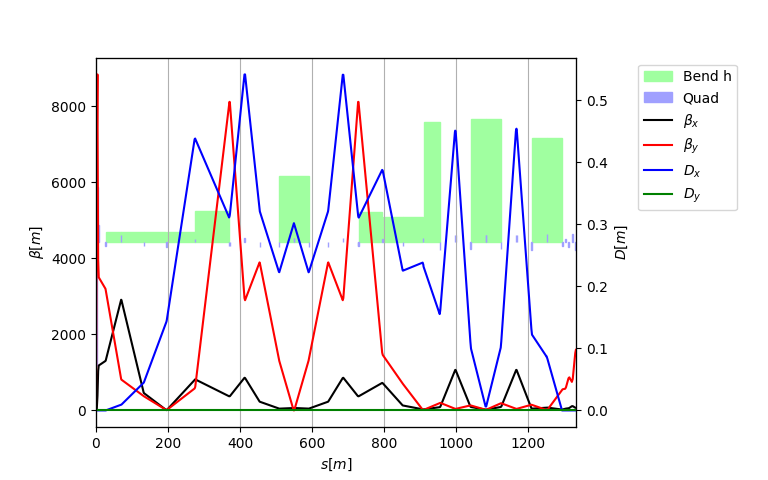

In [40]:
opt.plot()

### Extract and save quadrupole strengths

In [41]:
strengths = opt.get_knob_values()
xt.json.dump(strengths, 'strengths_quads_02_ffccsxl.json')

In [42]:
!cat strengths_quads_02_ffccsxl.json

{
 "kqf13l": 0.023628048420860314,
 "kqd14l": -0.024600454925909288,
 "kqf15l": 0.025603530657451024,
 "kqd16l": -0.011824373641377534,
 "kqf17l": 0.010300270092120837,
 "kqd18l": -0.013194118521584792,
 "kqf19l": 0.026163888081232444,
 "kqd20l": -0.02276215511540681,
 "kqd11l": -0.02433579760614267,
 "kqf12l": 0.021491999543328623,
 "kqd07l": -0.010836409106903441,
 "kqf08l": 0.009260717306993354,
 "kqd09l": -0.00974743963692992,
 "kqf10l": 0.013857826507375005,
 "kqx00l": 0.02122027958209072,
 "kqx01l": -0.021083201749766287,
 "kqx02l": 0.02119546033911493
}